In [1]:
import pandas as pd

#Read in full dataset
data = pd.read_csv('../dnn/language_identification/data/sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

In [2]:
lang = ['eng']
data = data[data['lang'].isin(lang)]

In [3]:
print(data.shape)

(1377753, 2)


In [4]:
hin_data = pd.read_csv('hi_romanized.csv')
print(hin_data.shape)

(23330, 1)


In [5]:
print(hin_data.head)

<bound method NDFrame.head of                                                     text
0       maiM mohana ke sAtha geMda khelane jA rahA hU.N|
1                    kyA tuma ise rAja़ rakha sakate ho?
2      evaresTa parvata duniyA kA sabase U.NchA parva...
3                          Apa kahA.N baiThanA chAheMge?
4                 agara tumhAre pAsa kAla yaMtra hotA...
...                                                  ...
23325       maiM eka niyukti sheDyUla karanA chAhatA hUM
23326                                  niyukti kA samaya
23327                       maiM eka niyukti chAhatA hUM
23328                            niyukti kI sUchI banAnA
23329                          anusUchI niyukti kRRipayA

[23330 rows x 1 columns]>


In [6]:
hin_data['lang'] = 'hi'

In [7]:
#Filter by text length
#len_cond = [True if 20<=len(s)<=200 else False for s in data['text']]
#data = data[len_cond]

#Filter by text language
#lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
#data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(25000,random_state = 100)
    data_trim = data_trim.append(lang_trim)

In [8]:
print(data_trim.head)

<bound method NDFrame.head of         lang                                               text
6269052  eng             Tom asked Mary if she liked Thai food.
7935492  eng                             I can't help drinking.
2143023  eng                 Could you all turn off the lights?
6523481  eng       Tom isn't going to be able to do that alone.
3918423  eng                      I never thought I'd find you.
...      ...                                                ...
7403705  eng                       She said she wanted to talk.
3417580  eng                        You're not as tall as I am.
6868333  eng                  I knew I should have married you.
6407568  eng  Mary didn't seem surprised when I told her Tom...
4664835  eng                   It's a major tourist attraction.

[25000 rows x 2 columns]>


In [9]:
data_trim = data_trim.append(hin_data,ignore_index=True)
print(data_trim.shape)

(48330, 2)


In [10]:
#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

train = data_shuffle[0:45000]
valid = data_shuffle[45000:47000]
test = data_shuffle[47000:48000]

In [11]:
print(data_trim.tail())

      lang                                          text
48325   hi  maiM eka niyukti sheDyUla karanA chAhatA hUM
48326   hi                             niyukti kA samaya
48327   hi                  maiM eka niyukti chAhatA hUM
48328   hi                       niyukti kI sUchI banAnA
48329   hi                     anusUchI niyukti kRRipayA


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def get_trigrams(corpus,n_feat=500):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus.values.astype('U'))
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names()
    
    return feature_names

In [13]:
#obtain trigrams from each language
features = {}
features_set = set()
lang = ['eng', 'hi']
for l in lang:
    print(l)
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

eng
hi


In [14]:
#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus.values.astype('U'))
#x = v.fit_transform(df['Review'].values.astype('U'))
feature_names = vectorizer.get_feature_names()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [15]:
#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

In [16]:
#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus.values.astype('U'))

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus.values.astype('U'))

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])

In [17]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Fit encoder
encoder = LabelEncoder()
encoder.fit(['eng', 'hi'])

def encode(y):
    """
    Returns a list of one hot encodings
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [19]:
from keras.models import Sequential
from keras.layers import Dense

#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

#Define model
model = Sequential()
model.add(Dense(500, input_dim=865, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=15, batch_size=100)

Epoch 1/15
450/450 [==============================] - 2s 5ms/step - loss: 0.0277 - accuracy: 0.9924
Epoch 2/15
450/450 [==============================] - 2s 4ms/step - loss: 0.0070 - accuracy: 0.9977
Epoch 3/15
450/450 [==============================] - 2s 5ms/step - loss: 0.0035 - accuracy: 0.9991
Epoch 4/15
450/450 [==============================] - 2s 5ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 5/15
450/450 [==============================] - 2s 5ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 6/15
450/450 [==============================] - 2s 5ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 7/15
450/450 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 8/15
450/450 [==============================] - 2s 5ms/step - loss: 6.4257e-04 - accuracy: 0.9999
Epoch 9/15
450/450 [==============================] - 2s 5ms/step - loss: 4.6241e-04 - accuracy: 0.9999
Epoch 10/15
450/450 [==============================] - 2s 5ms/step - loss: 5.5760e-04 - accu

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.996


Text(61.5, 0.5, 'Actual')

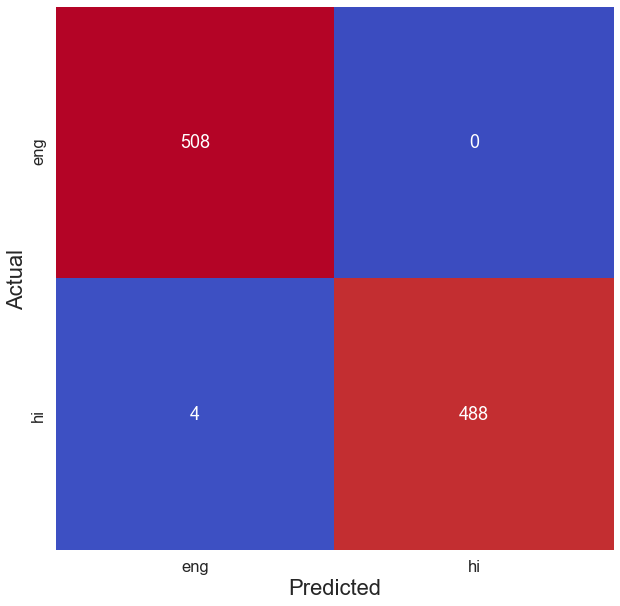

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']

#Get predictions on test set
labels = model.predict_classes(x_test)
predictions = encoder.inverse_transform(labels)

#Accuracy on test set
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['eng', 'hi']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

In [24]:
X = vectorizer.fit_transform(['I would like to apply for business loan'])
print(model.predict_classes(X))

[0]


In [22]:
from flask import Response, Flask, jsonify, request

In [23]:
from werkzeug.wrappers import Request, Response
from flask import Flask

app = Flask(__name__)

@app.route("/")
def hello():
    return "Hello World!"

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Nov/2020 16:04:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2020 16:04:23] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
app = Flask(__name__)

@app.route('/detect_lang', methods=['GET'])
def detect_lang():
    utterance = request.args.get('utterance')
    print(utterance)
    X = vectorizer.fit_transform([utterance])
    return str(model.predict_classes(X)[0])
    
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 5000, app)

 * Running on http://localhost:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Nov/2020 16:09:09] "GET /detect_lang?utterance=hi HTTP/1.1" 200 -


hi
uma hameshA ke lie to jApAna nahIM jA rahe


127.0.0.1 - - [06/Nov/2020 17:16:16] "GET /detect_lang?utterance=uma+hameshA+ke+lie+to+jApAna+nahIM+jA+rahe HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2020 17:16:33] "GET /detect_lang?utterance=where+can+i+apply+for+business+loan HTTP/1.1" 200 -


where can i apply for business loan


127.0.0.1 - - [06/Nov/2020 17:16:46] "GET /detect_lang?utterance=chAlU+khAtA+byAja+dara HTTP/1.1" 200 -


chAlU khAtA byAja dara


127.0.0.1 - - [06/Nov/2020 17:16:56] "GET /detect_lang?utterance=chAlU+khAtA+byAja+dara HTTP/1.1" 200 -


chAlU khAtA byAja dara


127.0.0.1 - - [06/Nov/2020 17:17:36] "GET /detect_lang?utterance=chAlU+khAtA+byAja+dara HTTP/1.1" 200 -


chAlU khAtA byAja dara


127.0.0.1 - - [06/Nov/2020 17:17:44] "GET /detect_lang?utterance=chAlU+khAtA+byAja+dara HTTP/1.1" 200 -


chAlU khAtA byAja dara


127.0.0.1 - - [06/Nov/2020 17:19:35] "GET /detect_lang?utterance=chAlU+khAtA+byAja+dara HTTP/1.1" 200 -


chAlU khAtA byAja dara


127.0.0.1 - - [06/Nov/2020 17:25:48] "GET /detect_lang?utterance=chAlU+khAtA+kholane+kI+prakriyA HTTP/1.1" 200 -


chAlU khAtA kholane kI prakriyA


127.0.0.1 - - [06/Nov/2020 17:27:45] "GET /detect_lang?utterance=chAlU+khAtA+kholane+kI+prakriyA HTTP/1.1" 200 -


chAlU khAtA kholane kI prakriyA


127.0.0.1 - - [06/Nov/2020 17:29:41] "GET /detect_lang?utterance=chAlU+khAtA+kholane+kI+prakriyA HTTP/1.1" 200 -


chAlU khAtA kholane kI prakriyA


127.0.0.1 - - [06/Nov/2020 17:30:03] "GET /detect_lang?utterance=chAlU+khAtA+kholane+kI+prakriyA HTTP/1.1" 200 -


chAlU khAtA kholane kI prakriyA


127.0.0.1 - - [06/Nov/2020 17:30:15] "GET /detect_lang?utterance=maiM+eka+niyukti+chAhatA+hUM HTTP/1.1" 200 -


maiM eka niyukti chAhatA hUM


127.0.0.1 - - [06/Nov/2020 17:45:24] "GET /detect_lang?utterance=i+need+10+lakh+rupees+at+5%25+tomorrow HTTP/1.1" 200 -


i need 10 lakh rupees at 5% tomorrow


127.0.0.1 - - [06/Nov/2020 17:45:57] "GET /detect_lang?utterance=chAlU+khAte+ke+lie+byAja+dara+kyA+hai+agla+somavar HTTP/1.1" 200 -


chAlU khAte ke lie byAja dara kyA hai agla somavar


127.0.0.1 - - [06/Nov/2020 18:00:45] "GET /detect_lang?utterance=business+loan+application HTTP/1.1" 200 -


business loan application


127.0.0.1 - - [06/Nov/2020 18:01:08] "GET /detect_lang?utterance=vyaapar+run+ke+liye+aavedhan+karna HTTP/1.1" 200 -


vyaapar run ke liye aavedhan karna


127.0.0.1 - - [06/Nov/2020 18:02:41] "GET /detect_lang?utterance=vyaapaar+run+ke+liye+aavedhan+karna HTTP/1.1" 200 -


vyaapaar run ke liye aavedhan karna


127.0.0.1 - - [06/Nov/2020 18:02:51] "GET /detect_lang?utterance=vyaapar+run+ke+liye+aavedhan+karnaa HTTP/1.1" 200 -


vyaapar run ke liye aavedhan karnaa


127.0.0.1 - - [06/Nov/2020 18:03:03] "GET /detect_lang?utterance=vyaapaar+run+ke+liye+aavedhan+karnaa HTTP/1.1" 200 -


vyaapaar run ke liye aavedhan karnaa


127.0.0.1 - - [06/Nov/2020 18:23:09] "GET /detect_lang?utterance=business+loan+राशि HTTP/1.1" 200 -


business loan राशि


127.0.0.1 - - [06/Nov/2020 18:25:27] "GET /detect_lang?utterance=current+account+खुला HTTP/1.1" 200 -


current account खुला


127.0.0.1 - - [06/Nov/2020 18:32:21] "GET /detect_lang?utterance=Quiero+solicitar+un+préstamo+personal HTTP/1.1" 200 -


Quiero solicitar un préstamo personal


127.0.0.1 - - [06/Nov/2020 18:32:49] "GET /detect_lang?utterance=நான்+தனிப்பட்ட+கடனுக்கு+விண்ணப்பிக்க+விரும்புகிறேன் HTTP/1.1" 200 -


நான் தனிப்பட்ட கடனுக்கு விண்ணப்பிக்க விரும்புகிறேன்


127.0.0.1 - - [06/Nov/2020 18:33:01] "GET /detect_lang?utterance=నేను+వ్యక్తిగత+రుణం+కోసం+దరఖాస్తు+చేయాలనుకుంటున్నాను HTTP/1.1" 200 -


నేను వ్యక్తిగత రుణం కోసం దరఖాస్తు చేయాలనుకుంటున్నాను


127.0.0.1 - - [06/Nov/2020 18:33:14] "GET /detect_lang?utterance=నేను+personal+loan+కోసం+దరఖాస్తు+చేయాలనుకుంటున్నాను HTTP/1.1" 200 -


నేను personal loan కోసం దరఖాస్తు చేయాలనుకుంటున్నాను


127.0.0.1 - - [06/Nov/2020 18:33:41] "GET /detect_lang?utterance=నేను+క్రెడిట్+కార్డు+కోసం+దరఖాస్తు+చేయాలనుకుంటున్నాను HTTP/1.1" 200 -


నేను క్రెడిట్ కార్డు కోసం దరఖాస్తు చేయాలనుకుంటున్నాను


127.0.0.1 - - [06/Nov/2020 18:33:52] "GET /detect_lang?utterance=నేను+డెబిట్+కార్డు+కోసం+దరఖాస్తు+చేయాలనుకుంటున్నాను HTTP/1.1" 200 -


నేను డెబిట్ కార్డు కోసం దరఖాస్తు చేయాలనుకుంటున్నాను


127.0.0.1 - - [06/Nov/2020 18:34:19] "GET /detect_lang?utterance=我想申请借记卡 HTTP/1.1" 200 -


我想申请借记卡


127.0.0.1 - - [06/Nov/2020 18:34:45] "GET /detect_lang?utterance=我可以添加信用卡嗎 HTTP/1.1" 200 -


我可以添加信用卡嗎


127.0.0.1 - - [06/Nov/2020 19:04:09] "GET /detect_lang?utterance=I+want+to+apply+for+personal+loan HTTP/1.1" 200 -


I want to apply for personal loan


127.0.0.1 - - [06/Nov/2020 19:04:41] "GET /detect_lang?utterance=muje+personal+loan+chahiye HTTP/1.1" 200 -


muje personal loan chahiye


127.0.0.1 - - [06/Nov/2020 19:06:45] "GET /detect_lang?utterance=i+want+to+watch+a+movie HTTP/1.1" 200 -


i want to watch a movie


127.0.0.1 - - [06/Nov/2020 19:08:20] "GET /detect_lang?utterance=i+want+10+lakhs+of+personal+loan HTTP/1.1" 200 -


i want 10 lakhs of personal loan


127.0.0.1 - - [06/Nov/2020 19:08:45] "GET /detect_lang?utterance=muje+das+lakh+loan+chahiye HTTP/1.1" 200 -


muje das lakh loan chahiye


127.0.0.1 - - [06/Nov/2020 19:14:29] "GET /detect_lang?utterance=mujhe+personal+loan+chaahiye HTTP/1.1" 200 -


mujhe personal loan chaahiye


127.0.0.1 - - [06/Nov/2020 19:16:18] "GET /detect_lang?utterance=mujhe+credit+card+apply+karna+chaahiye HTTP/1.1" 200 -


mujhe credit card apply karna chaahiye
hi


127.0.0.1 - - [26/Nov/2020 23:01:57] "GET /detect_lang?utterance=hi HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 23:22:40] "GET /detect_lang?utterance=mujhe+current+account+open+karna HTTP/1.1" 200 -


mujhe current account open karna


127.0.0.1 - - [26/Nov/2020 23:23:07] "GET /detect_lang?utterance=mujhe+current+account+open+chahiye HTTP/1.1" 200 -


mujhe current account open chahiye


127.0.0.1 - - [27/Nov/2020 06:48:31] "GET /detect_lang?utterance=hi HTTP/1.1" 200 -


hi


127.0.0.1 - - [27/Nov/2020 06:50:23] "GET /detect_lang?utterance=hi HTTP/1.1" 200 -


hi


127.0.0.1 - - [27/Nov/2020 06:50:46] "GET /detect_lang?utterance=i+want+to+apply+for+10+lakh+personal+loan HTTP/1.1" 200 -


i want to apply for 10 lakh personal loan
